<a href="https://colab.research.google.com/github/DavidAshraf/Logo-Classifier/blob/master/Logo_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pillow==4.1.1
!pip install torchvision

In [0]:
from torchvision import transforms, models, datasets
import torch
import numpy as np 
from google.colab import drive
import matplotlib.pyplot as plt


In [4]:
drive.mount('/content/drive', force_remount=True)
drive_root = '/content/drive/My Drive/LogoClassifier/'


Mounted at /content/drive


In [5]:
#Download data
root = 'http://www.multimedia-computing.de/flickrlogos/data/'
flickr47_train = root + 'FlickrLogos-32_dataset_v2.zip'
!wget {flickr47_train}
!unzip FlickrLogos-32_dataset_v2.zip
!ls


--2019-01-01 10:41:08--  http://www.multimedia-computing.de/flickrlogos/data/FlickrLogos-32_dataset_v2.zip
Resolving www.multimedia-computing.de (www.multimedia-computing.de)... 137.250.173.18
Connecting to www.multimedia-computing.de (www.multimedia-computing.de)|137.250.173.18|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3363984300 (3.1G) [application/zip]
Saving to: ‘FlickrLogos-32_dataset_v2.zip.2’

2.zip.2               8%[>                   ] 266.58M  39.0MB/s    eta 76s    ^C
Archive:  FlickrLogos-32_dataset_v2.zip
replace FlickrLogos-v2/all.filenames.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: drive			       FlickrLogos-32_dataset_v2.zip.1	FlickrLogos-v2
FlickrLogos-32_dataset_v2.zip  FlickrLogos-32_dataset_v2.zip.2	sample_data


In [6]:
!ls FlickrLogos-v2/classes/jpg

adidas	carlsberg  erdinger  fosters   milka	 rittersport   texaco
aldi	chimay	   esso      google    no-logo	 shell	       tsingtao
apple	cocacola   fedex     guiness   nvidia	 singha        ups
becks	corona	   ferrari   heineken  paulaner  starbucks
bmw	dhl	   ford      HP        pepsi	 stellaartois


In [0]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomRotation(10),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      normalize])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalize])

In [26]:
trainset = datasets.ImageFolder('FlickrLogos-v2/classes/jpg', transform=train_transforms)
validset = datasets.ImageFolder('FlickrLogos-v2/classes/jpg', transform=valid_transforms)
testset = datasets.ImageFolder('FlickrLogos-v2/classes/jpg', transform=valid_transforms)


# Shuffling and Splitting Dataset
np.random.seed(0)

dataset_size = len(dataset)
train_split= 0.8
validate_split = 0.1
test_split = 0.1
train_size = int(train_split * dataset_size)
validation_size = int(validate_split * dataset_size)
test_size = int(dataset_size - train_size - validation_size)


indices = list(range(dataset_size))
np.random.shuffle(indices)
train_indices = indices[:train_size]
temp = int(train_size+validation_size)
val_indices = indices[train_size:temp]
test_indices = indices[temp:]

print("Full set size:", len(trainset))

trainset = torch.utils.data.Subset(trainset, train_indices)
validset = torch.utils.data.Subset(validset, val_indices)
testset = torch.utils.data.Subset(testset, test_indices)

print("Train set size:", len(trainset))
print("Valid set size:", len(validset))
print("Test set size:", len(testset))

batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64)

Full set size: 8240
Train set size: 6592
Valid set size: 824
Test set size: 824


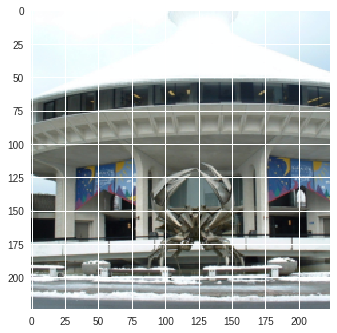

In [17]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
  
im, l = next(iter(trainloader))
i = im[1]
imshow(i)

In [0]:
classifier = torch.nn.Sequential(torch.nn.Linear(2048, 1024),
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(p=0.1),
                                 torch.nn.Linear(1024, 512),
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(p=0.1),
                                 torch.nn.Linear(512, 33),
                                 torch.nn.LogSoftmax(dim=1))

model = models.resnet152(pretrained=True)
# Freezing Parameters
for parameter in model.parameters():
    parameter.requires_grad = False
    
# Replacing the classifier layer
model.fc = classifier

criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [0]:
# Training

def train(model, criterion, optimizer, scheduler, start_epoch, epochs, cp, cp_path, best=np.Inf):
  model.to('cuda')
  min_validation_loss = best
  train_losses_list = []
  valid_losses_list = []

  for e in range(start_epoch, epochs+1):
    
    train_losses = 0
    train_accuracy = 0
    validation_losses = 0
    validation_accuracy = 0
#     scheduler.step()
    model.train()

    for images, labels in trainloader:
      images, labels = images.to('cuda'), labels.to('cuda')

      optimizer.zero_grad()
      log_ps = model(images)
      loss = criterion(log_ps, labels)

      loss.backward()
      optimizer.step()

      train_losses += loss.item() * images.size(0)
      
      ps = torch.exp(log_ps)
      top_ps, top_class = ps.topk(1, dim=1)
      equal = top_class == labels.view(*top_class.shape)
      train_accuracy += torch.sum(equal.type(torch.FloatTensor))



    model.eval()  
    with torch.no_grad():  
      for images, labels in validloader:
        images, labels = images.to('cuda'), labels.to('cuda')

        log_ps = model(images)
        loss = criterion(log_ps, labels) 
        validation_losses += loss.item() * images.size(0)

        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)
        equal = top_class == labels.view(*top_class.shape)
        validation_accuracy += torch.sum(equal.type(torch.FloatTensor))

    train_losses_list.append(train_losses/len(trainloader.dataset))
    valid_losses_list.append(validation_losses/len(validloader.dataset))

    print("Epoch: {}\t Training Loss: {}\t Training Accuracy: {}\t Validation Loss: {}\t Validation Accuracy: {}\t".format(
         e+1,
         train_losses/len(trainloader.dataset),
         100*train_accuracy/len(trainloader.dataset),
         validation_losses/len(validloader.dataset),
         100*validation_accuracy/len(validloader.dataset)))

    if validation_losses <= min_validation_loss:
      min_validation_loss = validation_losses
      print("Saving Model")
      cp['state_dict'] = model.state_dict()
      cp['optimizer'] = optimizer.state_dict()
      cp['epochs'] = e+1
      cp['loss'] = validation_losses
      cp['accuracy'] = validation_accuracy
      torch.save(cp, cp_path)

  
  plt.plot(train_losses_list, label='T')
  plt.plot(valid_losses_list, label='V')
  plt.legend(frameon=False)

In [0]:
cp = {'class_to_idx':dataset.class_to_idx,
      'model':models.resnet152(pretrained=True),
      'classifier':classifier,
      'batch_size':batch_size}
cp_path = drive_root + 'no-aug.pt'

model.class_to_idx = dataset.class_to_idx

train(model, criterion, optimizer, None, 0, 50, cp, cp_path)

Epoch: 1	 Training Loss: 1.6172705310062296	 Training Accuracy: 67.0206298828125	 Validation Loss: 1.196366805474735	 Validation Accuracy: 75.48543548583984	
Saving Model
Epoch: 2	 Training Loss: 1.1865604884416154	 Training Accuracy: 72.54247283935547	 Validation Loss: 0.951581264005124	 Validation Accuracy: 75.84951782226562	
Saving Model
Epoch: 3	 Training Loss: 1.1078066154591089	 Training Accuracy: 73.2706298828125	 Validation Loss: 0.8664271698414701	 Validation Accuracy: 76.21359252929688	
Saving Model
Epoch: 4	 Training Loss: 0.9965954799096561	 Training Accuracy: 74.6207504272461	 Validation Loss: 0.8160757295136313	 Validation Accuracy: 79.24757385253906	
Saving Model
Epoch: 5	 Training Loss: 0.8929506650248777	 Training Accuracy: 77.03276824951172	 Validation Loss: 0.6777559588256391	 Validation Accuracy: 81.43203735351562	
Saving Model
Epoch: 6	 Training Loss: 0.8050152046009175	 Training Accuracy: 79.23240661621094	 Validation Loss: 0.6546394379393569	 Validation Accuracy:

In [0]:
!ls 

drive  sample_data
